## A BRIEF LOOK AT TURKISH ECONOMICS

#### Preliminary Report

Author: Ugur Ural
17.07.2018

### SUMMARY

This notebook is a preliminary analysis of the Turkish economics. For now only done as a proof of concept and will be the base of a larger project later.

The structure is as follows:

#### Data
** Read data in
** Correct for column names and the wrong formatted columns (to be improved)
** Do a couple of unit conversions for privatisation gains and GDP

#### Exploratory analysis
** Plotting the interesting variables to make simple observations

#### Linear regression model
** Building a linear regression model used both for linear and exponential relationships
** Testing our model, against scikit-learn's in-built model.

#### Looking at correlations in the data
** Employment data is shown by sector.
** Correlation map of the data is made.

#### Modelling (Toy Model)
** Very basic model of the food price index, finding the important variables. It gives the same information we already got from the correlation matrix.
** It's a toy model, very small data divided to test and train data sets, so that we can mimic machine learning. But not reasonable to do it so small.
** It shows a clear link between the total exports and food prices. This is really interesting.


##### DATA Notes

1. The data in this project come from https://evds2.tcmb.gov.tr, the website of the Turkish Central Bank.

2. The next step will be to get the more comprehensive data of the Turkish Statistics Institute.

3. Currently we have data for:
     
     * External debts

     * GDP
     
     * Price Indices (production and consumption) 
     
     * Privatisation Gains (only total monatery gains)
     
     * Sectoral employment (very incomplete)
     
     * Sectoral production
     
     * Gold, currency
     
     
4) To be added:

    * Nominal GDPPPP
    
    * Privatisation sectors and targets
    
    * Unemployment numbers (including gender).
    
    * Production and private sector firm's numbers per sector (especially textile, agriculture, mining and heavy industry)
    
    
5) Specifics
    
    * Education in the imp_exp data set is the Consuper Price Index for education (cost to people); while educ_state in the budget data set is the education expenditure by the government.
    
    * In the first part of the code, the analysis is done without imputing missing data. In the second part, where different data frames are combined, correlations are searched and machine learning is used, we deal with missing data first.
    
    
    
    
    


### Importing Modules

In [147]:
# for general control
import datetime as dt
import time
import sys
import math
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings("ignore")
import scipy.stats
from scipy.optimize import curve_fit
from lmfit import Model
from lmfit.models import SkewedGaussianModel

# for data handling
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import re

# for plotting
import matplotlib.pyplot as plt
import matplotlib as mplib
from matplotlib import rc
import seaborn as sns
# show matlplotlib output in notebook
%matplotlib inline

# for machine learning
import sklearn

from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.metrics import *
from sklearn.externals import joblib
from sklearn.preprocessing import Imputer,scale, StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline




### Column Names

The column list of the data set is defined here based on the information from the TCMB data page: https://evds2.tcmb.gov.tr

This can be made in a more elegant way later.

In [150]:
## Defince column names

# External Debt data
ext_debt_col = ["Date","Total_Debt","Short","Long_4A","Long_State_Owned",\
                        "Long_4B","Priv_Debt","Financial_Inst","Finance_woBanks",\
                        "Private_Invest","Commercial_Banks","Official","Governmental",\
                        "International","IMF","Other_international"]

# Import - Export - Consumer Prices
imp_exp_col = ["Date","Living","Health","Education","Food_Drinks","Food",\
                        "Export","Import","Invest_export","Invest_import",\
                        "Consume_export","Consume_Import"]

# Import - Export: GDP
gdp_in_col = ["Date","GDP_consumer","GDP_earnings","New_Firms","New_Firms_Finance","Closing"]

# Privatisation
priv_in_col = ["Date","Priv_Gain"]

# Employment - Budget
emp_bud_col = ["Date","Help_Pol_Par","Agri_support","Animal_support",\
               "Agri_Reform_Proj","Tot_Emp","Agriculture","Mining",
               "Production","Resources","Building",\
               "Commerce","Transport","Communication","Finance_Insurance",\
               "Immovable","Scientific_Technical","Management_support",\
               "Public_Defense", "Educ_state","Health_Social",\
               "Culture_Art_Sport","Other_public"]
# Notes: Resources was "Elec_Gas_Hydro_Water_Canalisation"
# Agriculture was "Emp_agr_fors_fish"

# Production
prod_col = ["Date","Prod_elec_GWh","Prod_export","Prod_import","Consump",\
            "Tot_Industry","Mining","Production","Coal_Lignite","Prod_food",
            "Prod_textile","Prod_chemical"]

# Gold and Exchange Rate
gold_exc_col = ["Date","Gold_sales","Gold_price_ind","Official_gold_price","Ounce_Gold_London",\
           "Euro","Effective_exch"]

### Function to read the Excel files

### Read Data In

Reads 7 data files using the above function, converts the columns to numeric and does unit conversions of privatisation to billions and GDP to millions of dollars.

In [157]:
def read_data_in(file_in,column_list,lines):
    """Function to quickly read a number of lines from Excel and rename the columns for each\
    data"""
    indat = pd.read_excel(file_in)
    indat = indat.loc[0:lines]
    indat.columns = column_list
    return indat


In [159]:
# External Debts
ext_debt_in = read_data_in('EVDS_disborc.xlsx', ext_debt_col, 28)
ext_debt_in[["Date","Total_Debt","Short"]] = \
    ext_debt_in[["Date","Total_Debt","Short"]].apply(pd.to_numeric)

# Import Export data
imp_exp_in  = read_data_in('EVDS_ithalat_ihracat.xlsx', imp_exp_col, 149)
# converting all to float
imp_exp_in[["Health","Living"]] = imp_exp_in[["Health","Living"]].apply(pd.to_numeric)



# GDP data  (converting to millions)
gdp_in  = read_data_in('EVDS_gsyh_firma.xlsx', gdp_in_col, 20)
gdp_in[["Date","GDP_consumer","GDP_Earnings"]] = \
        gdp_in[["Date","GDP_consumer","GDP_earnings"]].apply(pd.to_numeric)
gdp_in[["GDP_consumer","GDP_earnings"]] = \
       gdp_in[["GDP_consumer","GDP_earnings"]].apply(lambda x: x/10**6)

    
    
# Privatisation data and conversion to billions of dollars
priv_in = read_data_in('EVDS_privatisation.xlsx',priv_in_col,32)
priv_in[["Priv_Gain","Date"]] = priv_in[["Priv_Gain","Date"]].apply(pd.to_numeric)
priv_in["Priv_Gain"] = priv_in["Priv_Gain"]/10**6.
Total_gains = priv_in["Priv_Gain"].sum()
nr_years  = max(priv_in["Date"]) - min(priv_in["Date"])
print(int(Total_gains)/1000, "Billions of Dollars gained from privatisation of State assets, in", nr_years,"years")



# Employment_Budget (employment given in 1000s)
emp_bud_in = read_data_in('EVDS_istihdam_butce.xlsx', emp_bud_col, 148)
emp_bud_in[["Help_Pol_Par","Agri_support"]] = emp_bud_in[["Help_Pol_Par","Agri_support"]].apply(pd.to_numeric)
emp_bud_in.iloc[:,5:] = emp_bud_in.iloc[:,5:].apply(lambda x: x*1000)
emp_bud_in.iloc[:,1:5] = emp_bud_in.iloc[:,1:5].apply(lambda x: x*1000)#TL



# Production
prod_col_in = read_data_in('EVDS_uretim.xlsx', prod_col, 37)
prod_col_in[["Prod_elec_GWh","Prod_export"]] =\
prod_col_in[["Prod_elec_GWh","Prod_export"]].apply(pd.to_numeric)


# Gold_exchange_rate
gold_exc_in = read_data_in('EVDS_altin_doviz.xlsx',gold_exc_col,149)
gold_exc_in[["Gold_sales","Gold_price_ind"]] = gold_exc_in[["Gold_sales","Gold_price_ind"]].\
apply(pd.to_numeric)


68.501 Billions of Dollars gained from privatisation of State assets, in 31.0 years


In [160]:
def convert_date(datafr):
    """Function cleaning up the data column. It takes the yearly average for every variable. """
    # Delete detail
    datafr["Date"] = datafr["Date"].str.split('-',n=1, expand = True)[0]
    datafr["Date"] = pd.to_numeric(datafr["Date"])
    
    #summarise with mean
    datafr = datafr.groupby(["Date"]).mean() 
    datafr = datafr.reset_index()

    return datafr


### Data Transformation



Converting the column "Date" from monthly to yearly data.



In [161]:
imp_exp_in = convert_date(imp_exp_in) 
prod_col_in = convert_date(prod_col_in)
emp_bud_in = convert_date(emp_bud_in)
gold_exc_in = convert_date(gold_exc_in)


Next: Check that the data still has all of the input.



all_data = [ext_debt_in, imp_exp_in, gdp_in, priv_in, emp_bud_in,
prod_col_in, gold_exc_in]

In [162]:
all_data = [ext_debt_in, imp_exp_in, gdp_in, priv_in, emp_bud_in,
           prod_col_in, gold_exc_in]

column_data = [ext_debt_col , imp_exp_col, gdp_in_col, priv_in_col, \
               emp_bud_col, prod_col, gold_exc_col]

# A list comprehension to quickly identify any missing columns.
for i in range(len(column_data)):
    lost=[x for x in column_data[i] if x not in all_data[i].columns]

    if len(column_data[i]) !=  len(all_data[i].columns):
        print('For the element '+str(i) +\
              ' of the all_data frame, original had'+ \
              str(lost) + ' columns that you lost.' )
    


For the element 2 of the all_data frame, original had[] columns that you lost.


### Plotting Function

This function plot multiple time series together.

In [165]:
def plot_pathways(dataset,var_col,date_col = "Date", pl_title = "", ylab = "",\
                  data_opt = "",var_opt = "", date_opt = "Date", ftype = "1"):
    """Function that can plot the time series for all data.
    Default is to plot multiple columns of a single data set.
    It can however, take two data sets as arguments to be 
    plotted together. To be tested"""
    
    new_pl = plt.figure()
    # First checking whether we need to do anything for the optional data
    if len(data_opt) != 0:
        opt = 1
        for i in var_opt:
            if type(i)==int:
                current_opt = data_opt.iloc[:,i]
            elif type(i)==str:
                current_opt = data_opt.loc[:,i]
            else:
                print("Error: You have a column name that is not an integer or string in the\
                OPTIONAL data frame", i, type(i))
                break
    else:
        opt = 0
        #print("No additional data given")

    # Now the main data set is subset
    for j in var_col:
        if type(j)==int:
            current = dataset.iloc[:,j]
        elif type(j)==str:
            current = dataset.loc[:,j]
        else:
            print("Error: You have a column name that is not an integer or string", j, type(j))
            break

        if opt == 0:
            new_pl = plt.plot(dataset[[date_col]],current, label=j)
        elif opt == 1:
            new_pl = plt.plot(dataset[[date_col]],current )
        new_pl = plt.title(pl_title)
        new_pl = plt.ylabel(ylab)    
               
    if opt == 1:
        if ftype == "logy":
            new_pl = plt.semilogy(data_opt[[date_col]],current_opt)  
        else:
            new_pl = plt.plot(data_opt[[date_col]],current_opt)  
 
    new_pl = plt.legend()
 

### Exploratory Data Analysis

#### 1. Help to the Political Parties as percentage of state budget

The 10-fold increase in the last 10 years (or 1 year), in the help to political parties from the state budget.

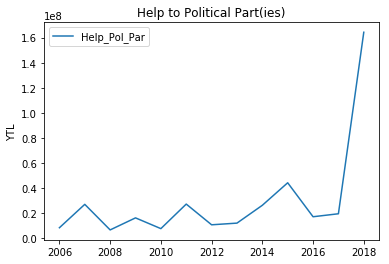

In [166]:

plot_pathways(emp_bud_in,["Help_Pol_Par"],"Date", pl_title = "Help to Political Part(ies)",\
                ylab = "YTL")


#### 2. Exponential increase of the Consumer Price Index for food.

In the news, it is reported that basic food such as onions and tomatoes are getting very expensive day by day. The figure support the hypothesis that the food prices seem to increase much faster than average inflation. This will be later modelled against fuel prices and exchange rate.

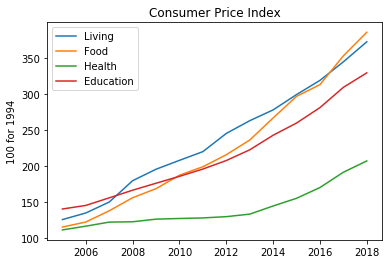

In [167]:
plot_pathways(imp_exp_in,["Living","Food","Health","Education"],"Date",\
              "Consumer Price Index","100 for 1994")



#### 3. External debts also increasing fast

Similarly and worryingly, external debst seem to grow exponentially too. Also the debts of the private sector, especially now that the currency lost 50% value in the last 5 years is worrying.

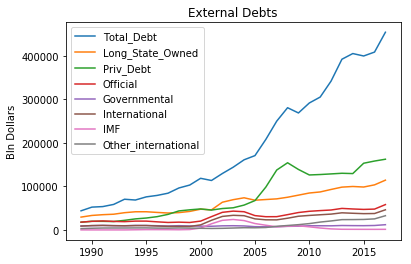

In [168]:
plot_pathways(ext_debt_in, ["Total_Debt","Long_State_Owned","Priv_Debt",\
                            "Official", "Governmental","International",\
                            "IMF","Other_international"],\
                "Date", "External Debts", "Bln Dollars")



#### 4. Gains from Privatisation

TO BE CLARIFIED: Despite the increase of gains from privatisation, the overall gain might not be quite as strong as suggested by the figure. The interesting data to find is the actual value of the institutions sold through privatisation. 

Combined with the sales of major investment institutions founded early in the Turkish Republic's life, like Sümerbank and Etibank that had large market shares in the textile and electricity/mining, as well as the increasing debts of all but especially the private sector, can impact the economy in the coming years. Sümerbank is an interesting case that can be studied separately. Always reporting gains until the late 80s, its value decreased substantially at the time as it got into the privatisation list. Especially as its immovables has been transferred freely to other institutions its debts increased drastically and it finally got privatised in 2004. 
https://www.evrensel.net/haber/146731/bir-ozellestirme-romani-sumerbank

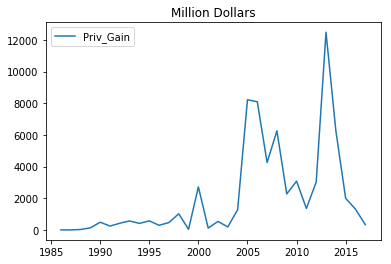

In [169]:
# For privatisation vs debt, using log scale
plot_pathways(priv_in,["Priv_Gain"], "Date","Million Dollars")


#### 4. Number of newly opening and closing firms

This data shows a large number of new companies being open, very likely related to the growth rate.

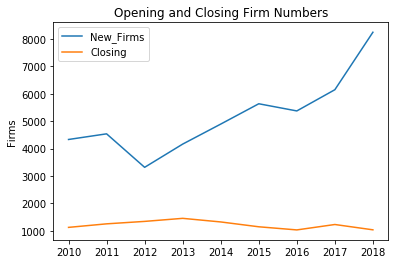

In [170]:
plot_pathways(gdp_in,["New_Firms","Closing"],"Date",\
              "Opening and Closing Firm Numbers","Firms")


### Linear Regression Model (Self-constructed)

The below function fits a linear regression model to the data, which will later be compared to the built-in models. For an exponential fit it only works on the base of e for now. It could have been written on a flexible base for versatility later. It works fine for the food price.

In [171]:
# Writing a fine-tuned linear regression model

def linreg(x,y, islog = False):
    """Minimising the distance between data and a regression line of y = ax + b.
    To be cleaned later by using the next function which is a separate distance
    calculator."""

    # normalisation of y and the constants
    if islog == True:
        y = np.log(y)

    # Normalisation
    norm_cte = max(y)
    y = y/norm_cte 
    b = min(y) 
    slope_guess = (y[(len(x)-1)] - y[0]) / (x[(len(x)-1)] - x[0])

    # number of iterations to find the slope
    n_try = 151
    k = -n_try*1/2
    
    a_list = np.zeros(n_try)
    dist = np.zeros(n_try)
    for j in range(n_try):
        k = k + 1
        
        # allowing a slope range of -+1.5 times the slope between the first and last points.
        a = slope_guess * ( 1 + float(k) / n_try ) 

        y_cal = np.empty(len(y))
        dist_s = np.zeros(len(y_cal))
        for i in range(len(x)):
            y_cal[i] = a * x[i] + b
        
        # Least-Squares: The distance of every fit point to the actual data
            dist_s[i] = (y_cal[i] - y[i])**2
        dist[j] = math.sqrt(sum(dist_s))
        a_list[j] = a
    
    # Find the slope that gave the minimum lsq.
    index = np.where(dist==min(dist))
    a_min = a_list[index]
    return index, min(dist), b, a_min,norm_cte

In [172]:
def plot_reg(x,y, islog = False, ylab = ""):
    """Plotting the regression line over data points, a and b should have been returned to 
    global, by the lin_reg function first."""
    reg_line =np.empty(len(x))
    plt.plot(x,y,'.b')
    
    for i in range(len(x)):
        if islog == True:
            reg_line[i] = np.exp((a*x[i] +b)* norm_cte)
            fcol = "m"
            ftitl = "Exponential fit"
        elif islog == False :
            reg_line[i] = (a*x[i] +b)* norm_cte
            fcol = "r"
            ftitl="Linear fit"
    reg_fig = plt.plot(x,reg_line, color = fcol)
    reg_fig = plt.title(ftitl)
    reg_fig = plt.xlabel("Year")
    reg_fig = plt.ylabel(ylab)
    return reg_line

#### Performance of LINREG compared to the Scikit-Learn Linear Regression

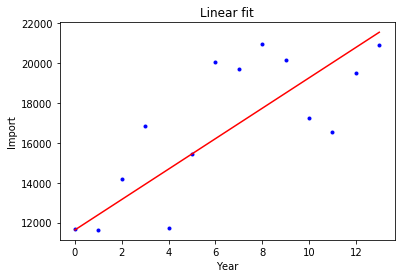

In [173]:
ind, mdist, b, a, norm_cte = linreg(imp_exp_in.index,imp_exp_in["Import"])
reg_line = plot_reg(imp_exp_in.index, imp_exp_in["Import"],ylab ="Import")

In [174]:
def distance(x_true, x_model):
    """Calculates the distance between two curves of same data points."""
    sizes = len(x_true)
    dist_s = np.zeros(sizes)
    
    for i in range(sizes):
        dist_s[i] = (x_true[i] - x_model[i])**2
    
    dist = math.sqrt(sum(dist_s))
    return dist

#### Using the linear regression from scikit-learn models

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

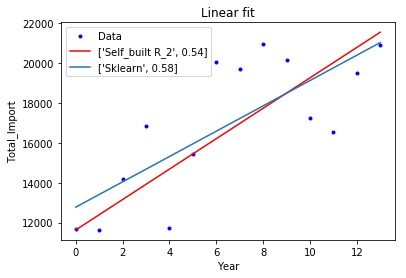

In [175]:
# Converting to scikit-learn's required data format
X = imp_exp_in.index.values.reshape(-1,1)
y = imp_exp_in['Import'].values.reshape(-1,1)

# calling linear regression
lin_reg_skl = LinearRegression(normalize = True)
lin_reg_skl.fit(X,y)
y_pred = lin_reg_skl.predict(X)

# calculate distance between y_pred and original y
dist_pred_sk = distance(y_pred[:,0], y[:,0])

# plot against our linear regression function's result
plot_self = plot_reg(imp_exp_in.index, imp_exp_in["Import"])

plot_sk = plt.plot(X, y_pred)
plt.sk = plt.ylabel("Total_Import")
r2_sk = sklearn.metrics.r2_score(y, y_pred)
r2_self = sklearn.metrics.r2_score(y, reg_line)
fig = plt.legend(["Data",["Self_built R_2", round(r2_self,2)],["Sklearn",round(r2_sk,2)]])

The linear regression algorithm does slightly better than ours but the R squared scores are in fact very close. The main reason is likely to be the coarse covering of the value space in our fit for the intercept and the slope, but overall, the algorithm is working close to optimal.

### Do the food prices really increase exponentially?

Unfortunately, yes.

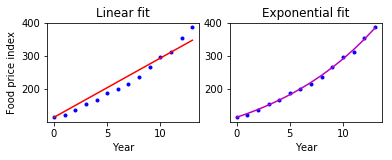

In [176]:
# optimistic linear fit try
fig = plt.subplot(2,2,1)
ind, mdist, b, a, norm_cte = linreg(imp_exp_in.index,imp_exp_in["Food"])
reg_food = plot_reg(imp_exp_in.index,imp_exp_in["Food"])
reg_food = plt.ylabel("Food price index")
#Let's fit an Exponential line
fig = plt.subplot(2,2,2)
ind, mdist, b, a, norm_cte = linreg(imp_exp_in.index,imp_exp_in["Food"],True)
reg_food_exp = plot_reg(imp_exp_in.index,imp_exp_in["Food"], True)
fig = plt.ylabel("")


### EMPLOYMENT DATA
 
Next, unemployment data per sector is to be analysed. The population of Turkey is 79.5 Million (2016 data), which is not great since the data here goes to 2014. But let's assume that those two years didn't make a big difference for now. 


In [177]:
### EMPLOYMENT DATA
columns = []
columns.append(0)
columns[1:len(emp_bud_in.columns)] = range(5,len(emp_bud_in.columns))

# Choosing employment data
emp_data = emp_bud_in.iloc[:,columns]
emp_data = emp_data.set_index(["Date"])
emp_data_norm = emp_data.apply(lambda x: x/(79.5*10**6))

##### Which sectors employ most people?


In [178]:
top_5 = emp_data.mean().sort_values(ascending = False)[1:6]
everything_else = sum(emp_data.mean().sort_values(ascending = False)[6:])

print("The mean employment by sector is largest in the following sectors:")
print(top_5)

The mean employment by sector is largest in the following sectors:
Agriculture       5.762903e+06
Production        4.358681e+06
Commerce          3.459583e+06
Building          1.598833e+06
Public_Defense    1.377778e+06
dtype: float64


#### The overall statistics are as follows

        Tot_Emp  Agriculture    Mining  Production  Resources  Building  \
count  6.000000     6.000000  6.000000    6.000000   6.000000  6.000000   
mean   0.300897     0.072489  0.001409    0.054826   0.002349  0.020111   
std    0.020823     0.004756  0.000129    0.003673   0.000531  0.002344   
min    0.267769     0.065998  0.001217    0.048737   0.001406  0.016382   
25%    0.289025     0.068757  0.001355    0.053336   0.002158  0.018811   
50%    0.307594     0.073805  0.001418    0.055330   0.002570  0.021101   
75%    0.315777     0.076415  0.001451    0.057584   0.002726  0.021458   
max    0.321083     0.076969  0.001605    0.058553   0.002749  0.022459   

       Commerce  Transport  Communication  Finance_Insurance  Immovable  \
count  6.000000   6.000000       6.000000           6.000000   6.000000   
mean   0.043517   0.014245       0.002749           0.003499   0.001720   
std    0.001126   0.001653       0.000448           0.000117   0.000741   
min    0.041883   0.0124

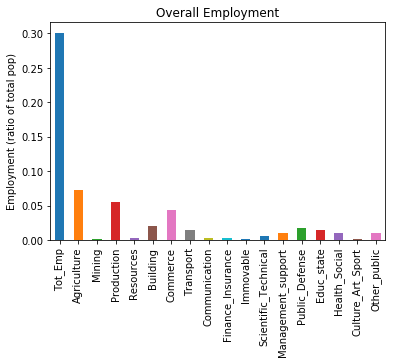

In [179]:
# Statistical description of the employment data.
desc= emp_data_norm.describe()
print(desc)

fig = emp_data_norm.mean().plot.bar(title = "Overall Employment")
fig =plt.ylabel("Employment (ratio of total pop)")
plt.show()

### Top Employment

The percentage of employment per sector, for the 5 top sectors.

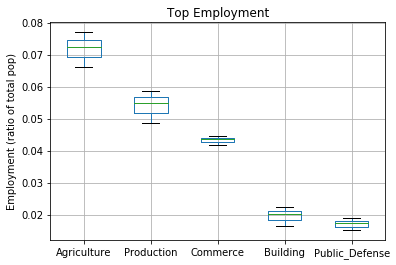

In [180]:
fig = pd.DataFrame(desc.loc[["mean","max","min"], top_5.index]).boxplot()
fig = plt.title("Top Employment")
fit = plt.ylabel("Employment (ratio of total pop)")
fig = plt.show()

### Distribution of Work Force

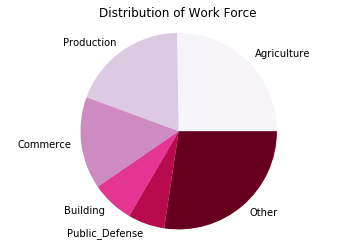

In [181]:
summary_data = top_5
summary_data["Other"] = everything_else 
ax = summary_data.plot(kind = "pie", colormap ="PuRd")
fig = plt.title("Distribution of Work Force")
fig = ax.axis("equal")
fig = ax.set_ylabel("")
fig = plt.show()

### Scikit-Learn for GDP Modelling

For now, we don't have any projections so we will just use the past data to find correlations and build models.

1. Let's put the consumer price, import_export data sets together.

2. Let's add columns from other data for total industrial production, education expenditure, value and sales of gold, total employment, total external debts and private sector's debts.



In [182]:
# Outer join to make sure we don't lose data
comb_data = imp_exp_in.merge(gdp_in, \
                             left_on = 'Date', right_on = 'Date', how='inner')

comb_data = comb_data.merge(ext_debt_in, on='Date', how = 'left')
comb_data = imp_exp_in.merge(gdp_in, \
                             left_on='Date', right_on='Date', how='inner')

ext_debt  =  ext_debt_in[["Total_Debt", "Priv_Debt"]]
emp_bud = emp_bud_in[["Tot_Emp","Educ_state"]]
gold_exc = gold_exc_in[["Gold_sales","Gold_price_ind", "Effective_exch"]]
prod_col = prod_col_in[["Tot_Industry"]]

comb_data = comb_data.merge(ext_debt, left_index = True ,right_index = True,how = 'left')
comb_data = comb_data.merge(prod_col, left_index = True ,right_index = True,how = 'left')


#### Correlation table

Before more sophisticated algorithms, let's also look at the correlations of some variables ourselves.


In [183]:
corr_table = comb_data.corr()
corr_table

,Date,Living,Health,Education,Food_Drinks,Food,Export,Import,Invest_export,Invest_import,Consume_export,Consume_Import,GDP_consumer,New_Firms,New_Firms_Finance,Closing,GDP_Earnings,Total_Debt,Priv_Debt,Tot_Industry
Date,1.000000,0.996751,0.901752,0.980538,0.984690,0.985144,0.891683,0.759176,0.825116,0.682542,0.938144,0.828752,0.713037,0.833680,0.405154,-0.431414,0.713037,0.984510,0.966407,0.869213
Living,0.996751,1.000000,0.924878,0.989332,0.992340,0.992535,0.883377,0.741909,0.832588,0.647112,0.933591,0.798696,0.682426,0.856152,0.423945,-0.447673,0.682426,0.987261,0.959982,0.853208
Health,0.901752,0.924878,1.000000,0.965752,0.959035,0.957915,0.717386,0.553187,0.797087,0.420173,0.814329,0.554903,0.532532,0.921977,0.573094,-0.579686,0.532532,0.935859,0.875065,0.837416
Education,0.980538,0.989332,0.965752,1.000000,0.999136,0.998975,0.835714,0.684909,0.825973,0.599218,0.915054,0.732713,0.663312,0.880904,0.478439,-0.494352,0.663312,0.986893,0.959083,0.877683
Food_Drinks,0.984690,0.992340,0.959035,0.999136,1.000000,0.999988,0.844770,0.696052,0.827347,0.609380,0.920107,0.746852,0.662447,0.890601,0.461970,-0.500115,0.662447,0.987518,0.962429,0.866811
Food,0.985144,0.992535,0.957915,0.998975,0.999988,1.000000,0.845685,0.697150,0.827343,0.611419,0.921026,0.748814,0.663983,0.890394,0.458625,-0.499171,0.663983,0.987592,0.963376,0.866490
Export,0.891683,0.883377,0.717386,0.835714,0.844770,0.845685,1.000000,0.942274,0.899112,0.786503,0.956043,0.880138,0.614219,0.478214,0.249244,0.181169,0.614219,0.826213,0.822900,0.845016
Import,0.759176,0.741909,0.553187,0.684909,0.696052,0.697150,0.942274,1.000000,0.808993,0.842286,0.880451,0.896252,0.488266,0.160487,0.333714,0.555377,0.488266,0.664977,0.670610,0.830638
Invest_export,0.825116,0.832588,0.797087,0.825973,0.827347,0.827343,0.899112,0.808993,1.000000,0.593989,0.868707,0.689359,0.523496,0.830663,0.544913,-0.221694,0.523496,0.794307,0.752321,0.687793
Invest_import,0.682542,0.647112,0.420173,0.599218,0.609380,0.611419,0.786503,0.842286,0.593989,1.000000,0.793454,0.925188,0.638195,-0.213023,0.011000,0.441795,0.638195,0.605615,0.690832,0.736451


Clearly the consumer price index (Food & living) is very correlated (approximately 84% and 88% respectively) with the share of export in consumed goods. Would that mean the prices increase inside the country as well if they are high for exporting? It could be that too much of produced food is exported, leaving the supply small in the country.

The exported goods also correlates strongly with the out-of-country debts of the private sector. Random, coincidence?

This is interesting. More later...

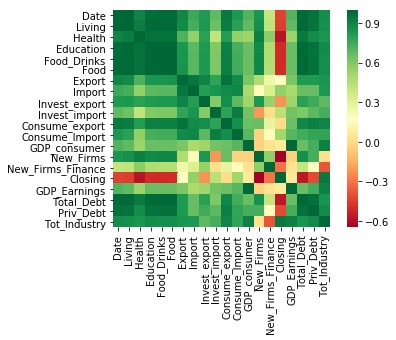

In [184]:
corr_table = comb_data.corr()
fig = sns.heatmap(corr_table, square=True, cmap='RdYlGn')


#### Top correlations

Later, I'll think of a better way of presenting the following but for now, the table shows for every variable the variable that it correlates with strongest (except for itself).

In [185]:
Max_cor = pd.DataFrame(\
                       corr_table[corr_table.columns].\
                       apply(lambda x: x.sort_values(ascending = False)[1]))

#Max_cor[0].rename("correlation")
Max_cor["Variable"] = corr_table[corr_table.columns].\
                       apply(lambda x: x.sort_values(ascending = False).index[1])

Max_cor["Variable"]

max_nr = Max_cor.groupby(["Variable"]).count()


Date                         Living
Living                         Date
Health                    Education
Education               Food_Drinks
Food_Drinks                    Food
Food                    Food_Drinks
Export               Consume_export
Import                       Export
Invest_export                Export
Invest_import        Consume_Import
Consume_export               Export
Consume_Import        Invest_import
GDP_consumer           GDP_consumer
New_Firms                    Health
New_Firms_Finance            Health
Closing                Tot_Industry
GDP_Earnings           GDP_Earnings
Total_Debt                     Food
Priv_Debt                Total_Debt
Tot_Industry                Closing
Name: Variable, dtype: object

From the top of the table health, education, food prices all are correlated with each other. 
Not surprising. However, we saw before that the food prices had the highest growth rates recently.

Electricity production is the variable that has the strongest correlations with others, especially total industrial production and the import budgets. Not surprising either. It can also be the one variable to exclude in the modelling as the others would mimic its effect anyway.

#PLOT THIS
Closing of new firms correlate with the education expenditure of the state as well as the debts
of the private sector. These are also closely related to total industrial production and employment.

The correlation between gold sales and employment is actually quite typical, as it is quite typical in Turkey to invest in gold when you can for fear of exchange rate's  instability. 

A note here, the exchange rate actually correlates with most variables but anti-correlation. Especially, with large loss of value  of the Turkish Lira against Euro in the past years (from 0.4 to 0.17 between July 2013 and July 2018 - www.xe.com) means large losses in every area. 

#### Note on Missing Data

Scikit learn has tools that can be used simply, to impute the missing data. We don't use it right now as it only replaces the data by the mean, median, or the most frequent, which is not great for the little data sets that we have that also are completely time dependent and we miss mainly the two ends of the time series... The best thing in this case is going to be to just get more data later.

 Rules: for the firms data we use 2010 values for earlier dates, if that's what's missing
 and the last available value when the later dates are missing (for total industry).
 For industy we  could later use a growth_rate, for now we use 2015 values for later.

In [186]:
comb_data = comb_data.replace("nan","NaN")

comb_data.loc[0:6,["New_Firms"]] = comb_data.loc[7,["New_Firms"]].values
comb_data.loc[0:6,["New_Firms_Finance"]] = comb_data.loc[7,["New_Firms_Finance"]].values
comb_data.loc[0:6,["Closing"]] = comb_data.loc[7,["Closing"]].values

comb_data.loc[10:15,"Tot_Industry"] = comb_data.loc[9,"Tot_Industry"]

# counting the total NAs left in the data frame.
comb_data.isna().sum().sum()

0

### Lasso modelling of the food prices

The Lasso model chooses the most significant variables in linear regression. 

##### Version 1. All data
Here, we expect Lasso to choose all of the inflation related variables to be correlated to the food price index and that's what it finds.

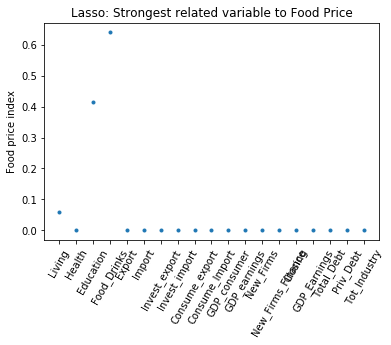

In [187]:
# Getting data into sklearn format
y = comb_data["Food"].values

# taking out the variables that are directly correlated (other price indices)
X = comb_data.drop(['Food','Date'], axis=1).values#.reshape(-1,1)
col = comb_data.columns.drop(['Food','Date'])

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, random_state = 4)

lasso = Lasso(alpha=0.4, normalize=True)

# Fit the pipeline to the train set
lasso = lasso.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = lasso.predict(X_test)

lasso_coef = lasso.coef_

# Plot the coefficients
fig = plt.plot(range(len(col)), lasso_coef,'.')
fig = plt.ylabel("Food price index")
fig = plt.title("Lasso: Strongest related variable to Food Price")
fig = plt.xticks(range(len(col)), col, rotation=60)


Living, education, food and drink prices are like the food price alone indicators for the inflation, and as expected the all correlate. Let's take them out, since that's not a causal effect.

##### Version 2. Data without inflation and date relations
Here, we take out the date as well, since we already showed that it's exponentially related to food price.

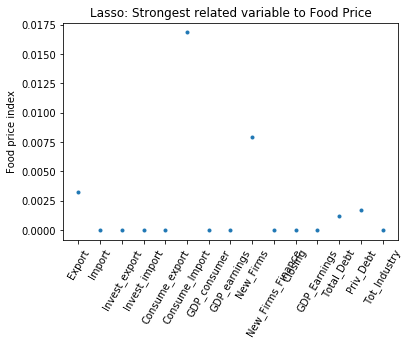

In [188]:
# Getting data into sklearn format
y = comb_data["Food"].values

# taking out the variables that are directly correlated (other price indices)
X = comb_data.drop(['Food','Food_Drinks','Living','Education','Health','Date'], axis=1).values#.reshape(-1,1)
col = comb_data.columns.drop(['Food','Food_Drinks','Living','Education','Health','Date'])

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, random_state = 4)

lasso = Lasso(alpha=0.4, normalize=True)

# Fit the pipeline to the train set
lasso = lasso.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = lasso.predict(X_test)

lasso_coef = lasso.coef_

# Plot the coefficients
fig = plt.plot(range(len(col)), lasso_coef,'.')
fig = plt.ylabel("Food price index")
fig = plt.title("Lasso: Strongest related variable to Food Price")
fig = plt.xticks(range(len(col)), col, rotation=60)



Now we have a model that shows that the food price is really dependant on the export share, GDP and external debts. 